# Depression and Wearables

This study looks at how to detect depression using physical activity data from wearable actigraphy devices. Using an openly available dataset, the analysis starts with summary statistics and behavioral feature extraction: average activity, standard deviation, maximum activity, and total activity per day.

These features help differentiate between healthy and depressed participants. I use machine learning models such as Logistic Regression, Random Forest, and XGBoost with reproducible participant-level splits (60:20:20 train/validation/test ratio). I evaluate the models through F1 scores, ROC, and AUC curves. Hyperparameter tuning with Optuna and GPU acceleration significantly improves performance.

Random Forest achieves the best macro F1-score of 0.74 and AUC of 0.82. I use SHAP analysis to improve interpretability, which confirms that activity patterns are relevant behavioral indicators. The results show that ensemble and boosting methods, along with strong experimental controls, effectively differentiate depression. This supports the use of sensor-based analytics in mental health research.

In [1]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 15.6 MB/s eta 0:00:00


In [2]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
from google.colab import files
uploaded = files.upload()  # Upload the ZIP file

Saving depresjon.zip to depresjon.zip


In [4]:
import zipfile

with zipfile.ZipFile('depresjon.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/depresjon')
import os
print(os.listdir('/content/depresjon/data'))

['control', 'condition', 'scores.csv']


In [5]:
def combine_data(path):
    dirs = os.listdir(path)
    combine_df = []

    for filepath in dirs:
        source = filepath.split('.')[0]
        if filepath.endswith('.csv'):
            X = pd.read_csv(path + filepath, parse_dates=['timestamp'], index_col='timestamp')
            X['source'] = source
            combine_df.append(X)

    return combine_df

In [6]:
combine_df = combine_data('/content/depresjon/data/condition/')

In [7]:
conditions = []
for condition in combine_df:
    condition_df = pd.DataFrame(columns=['mean_activity', 'std_activity', 'zero_activity_proportion', 'source'])
    condition_df['mean_activity'] = condition.activity.resample('H').mean()
    condition_df['std_activity'] = condition.activity.resample('H').std()
    condition_df['zero_activity_proportion'] = [data[1].tolist().count(0) for data in condition.activity.resample('H')]
    condition_df['source'] = condition.source
    conditions.append(condition_df)

/tmp/ipython-input-328107403.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  condition_df['mean_activity'] = condition.activity.resample('H').mean()
/tmp/ipython-input-328107403.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  condition_df['std_activity'] = condition.activity.resample('H').std()
/tmp/ipython-input-328107403.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  condition_df['zero_activity_proportion'] = [data[1].tolist().count(0) for data in condition.activity.resample('H')]
/tmp/ipython-input-328107403.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  condition_df['mean_activity'] = condition.activity.resample('H').mean()
/tmp/ipython-input-328107403.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instea

In [8]:
combine_df = combine_data('/content/depresjon/data/control/')

In [9]:
controls = []
for control in combine_df:
    control_df = pd.DataFrame(columns=['mean_activity', 'std_activity', 'zero_activity_proportion', 'source'])
    control_df['mean_activity'] = control.activity.resample('H').mean()
    control_df['std_activity'] = control.activity.resample('H').std()
    control_df['zero_activity_proportion'] = [data[1].tolist().count(0) for data in control.activity.resample('H')]
    control_df['source'] = control.source
    controls.append(control_df)

/tmp/ipython-input-830304810.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  control_df['mean_activity'] = control.activity.resample('H').mean()
/tmp/ipython-input-830304810.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  control_df['std_activity'] = control.activity.resample('H').std()
/tmp/ipython-input-830304810.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  control_df['zero_activity_proportion'] = [data[1].tolist().count(0) for data in control.activity.resample('H')]
/tmp/ipython-input-830304810.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  control_df['mean_activity'] = control.activity.resample('H').mean()
/tmp/ipython-input-830304810.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  control_df[

/tmp/ipython-input-2229710184.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[i].set_title(f'Mean activity for {condition.source[1]}', fontsize=18)


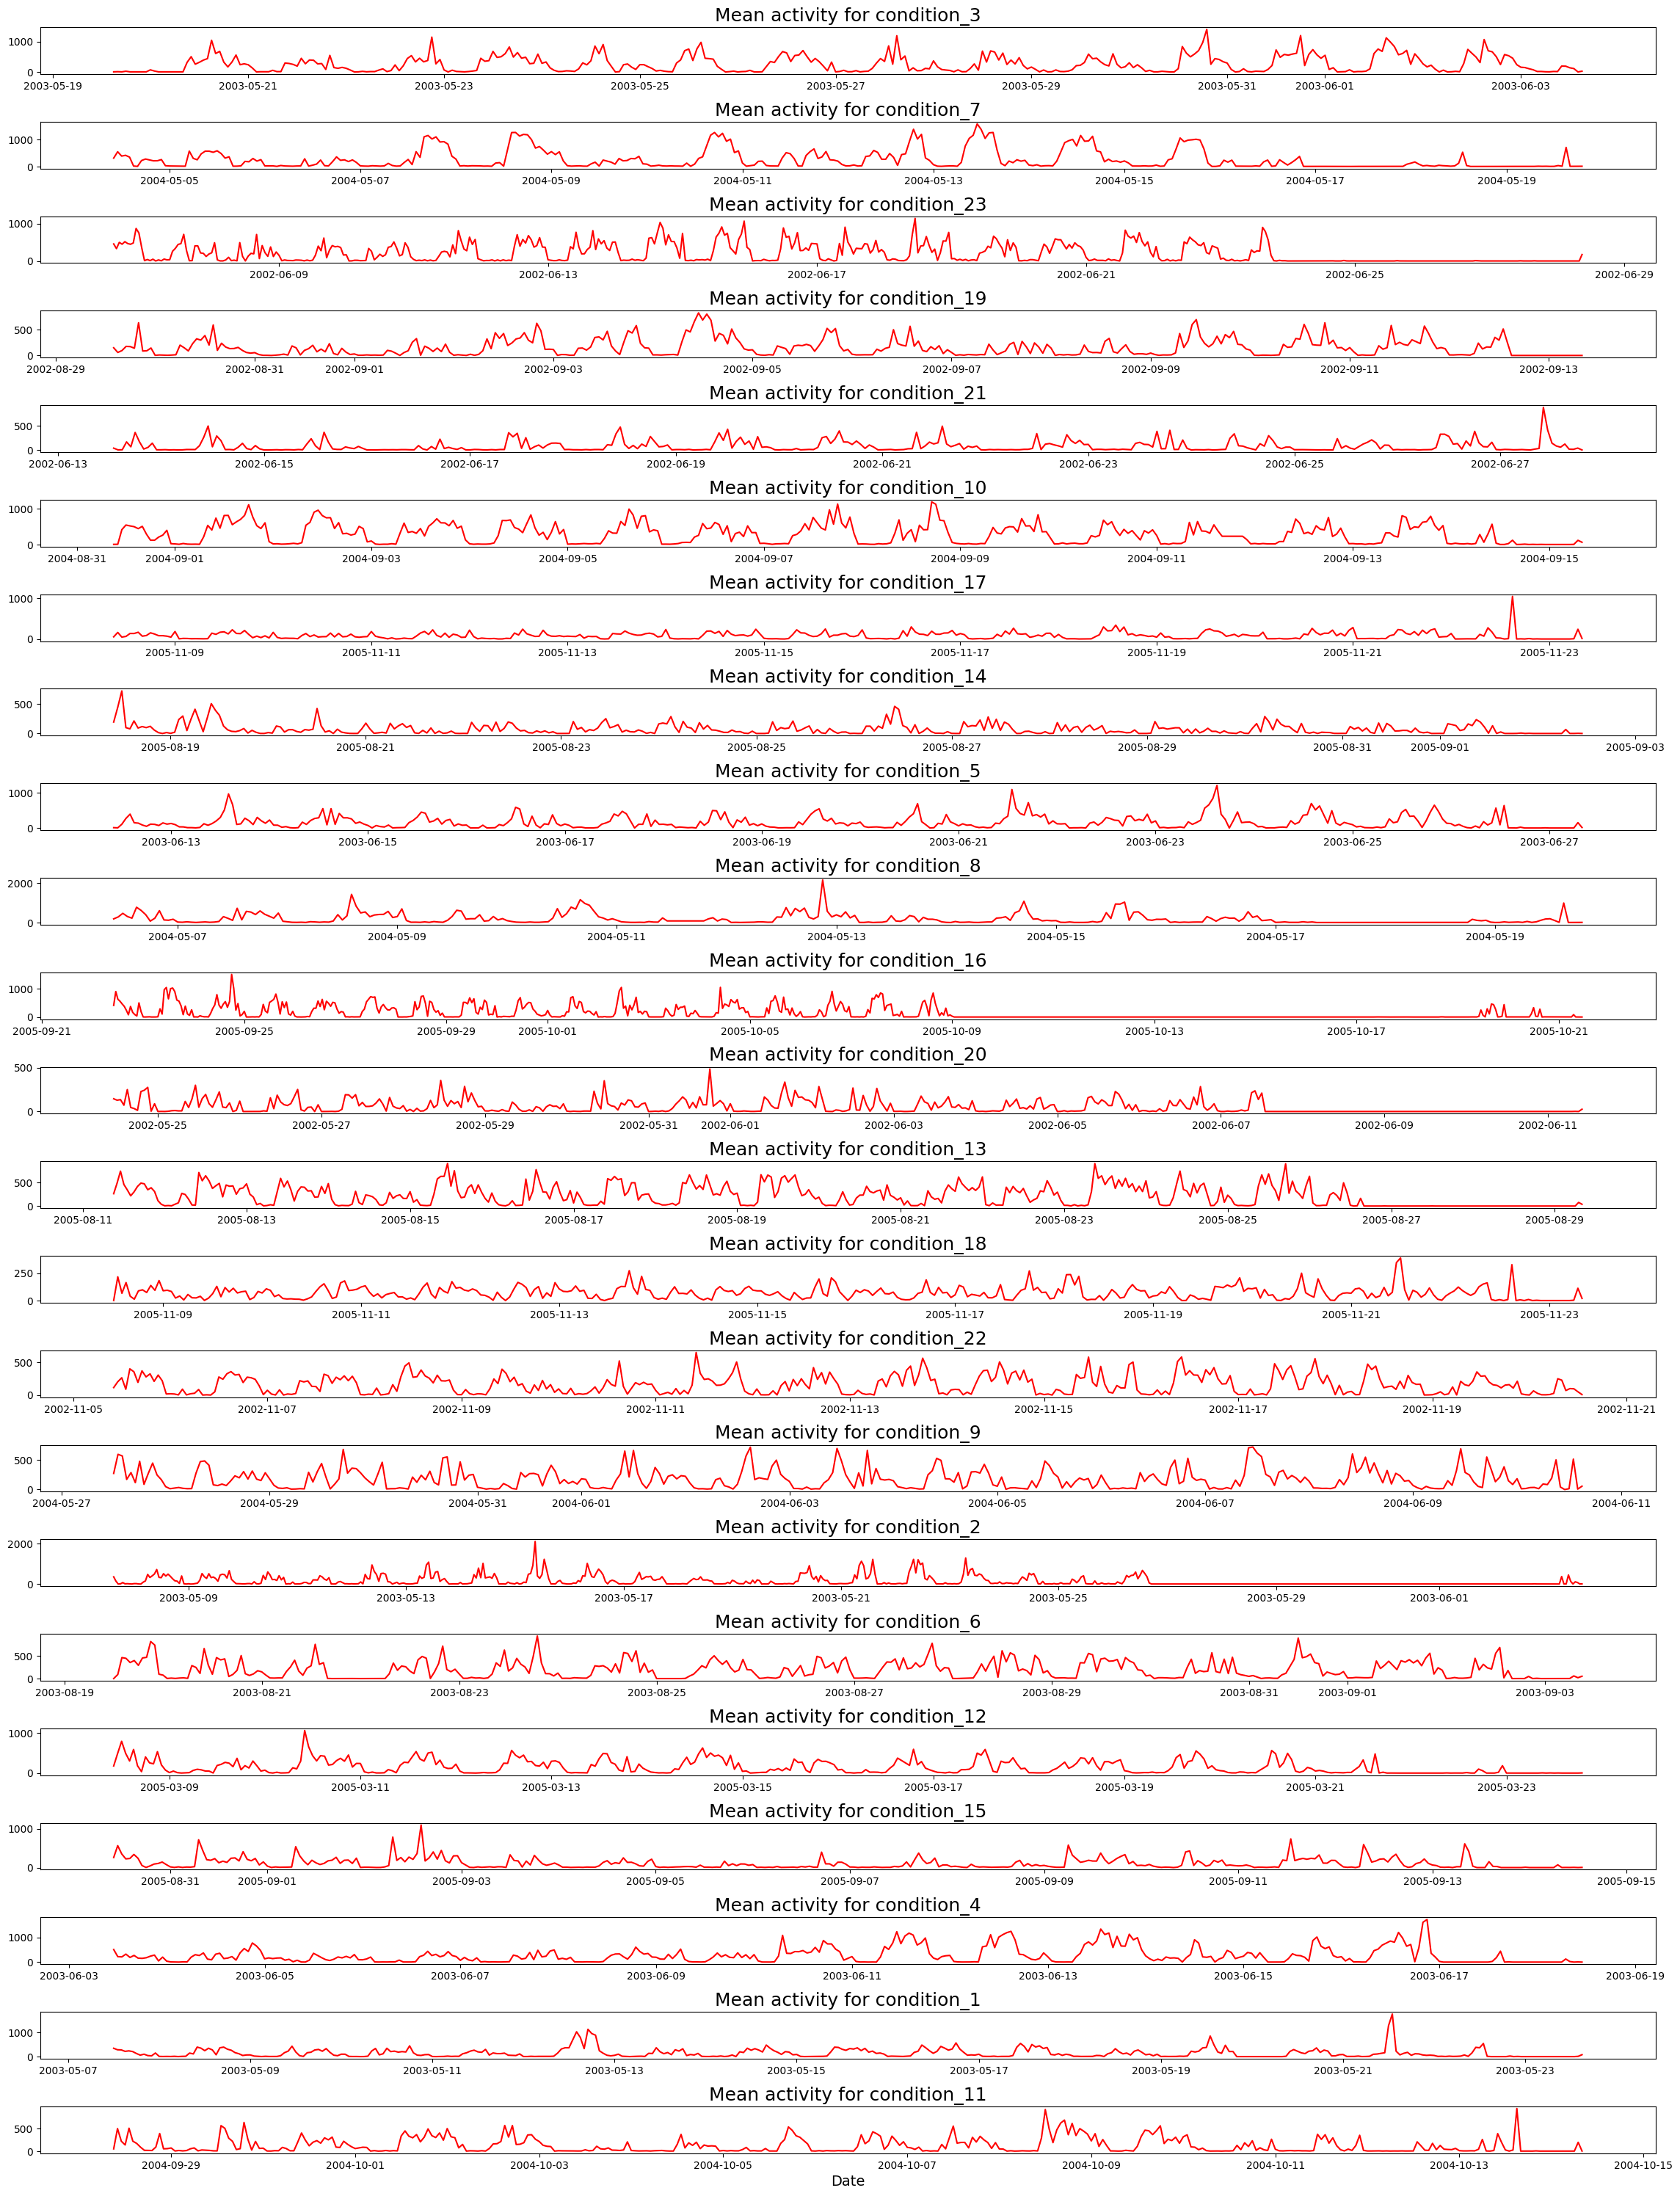

In [10]:
fig, axes = plt.subplots(23, 1, figsize=(23, 30))
cnt = 0
for i in range(23):
    condition = conditions[cnt]
    axes[i].plot(condition.index, condition.mean_activity, color='r')
    axes[i].set_title(f'Mean activity for {condition.source[1]}', fontsize=18)
    cnt += 1

plt.xlabel('Date', fontsize=14)
fig.tight_layout(pad=1.0)
fig.savefig('Mean activity of condition group.jpg', dpi=100)
plt.show()

/tmp/ipython-input-2664713107.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[i].set_title(f'Mean activity for {control.source[1]}', fontsize=18)


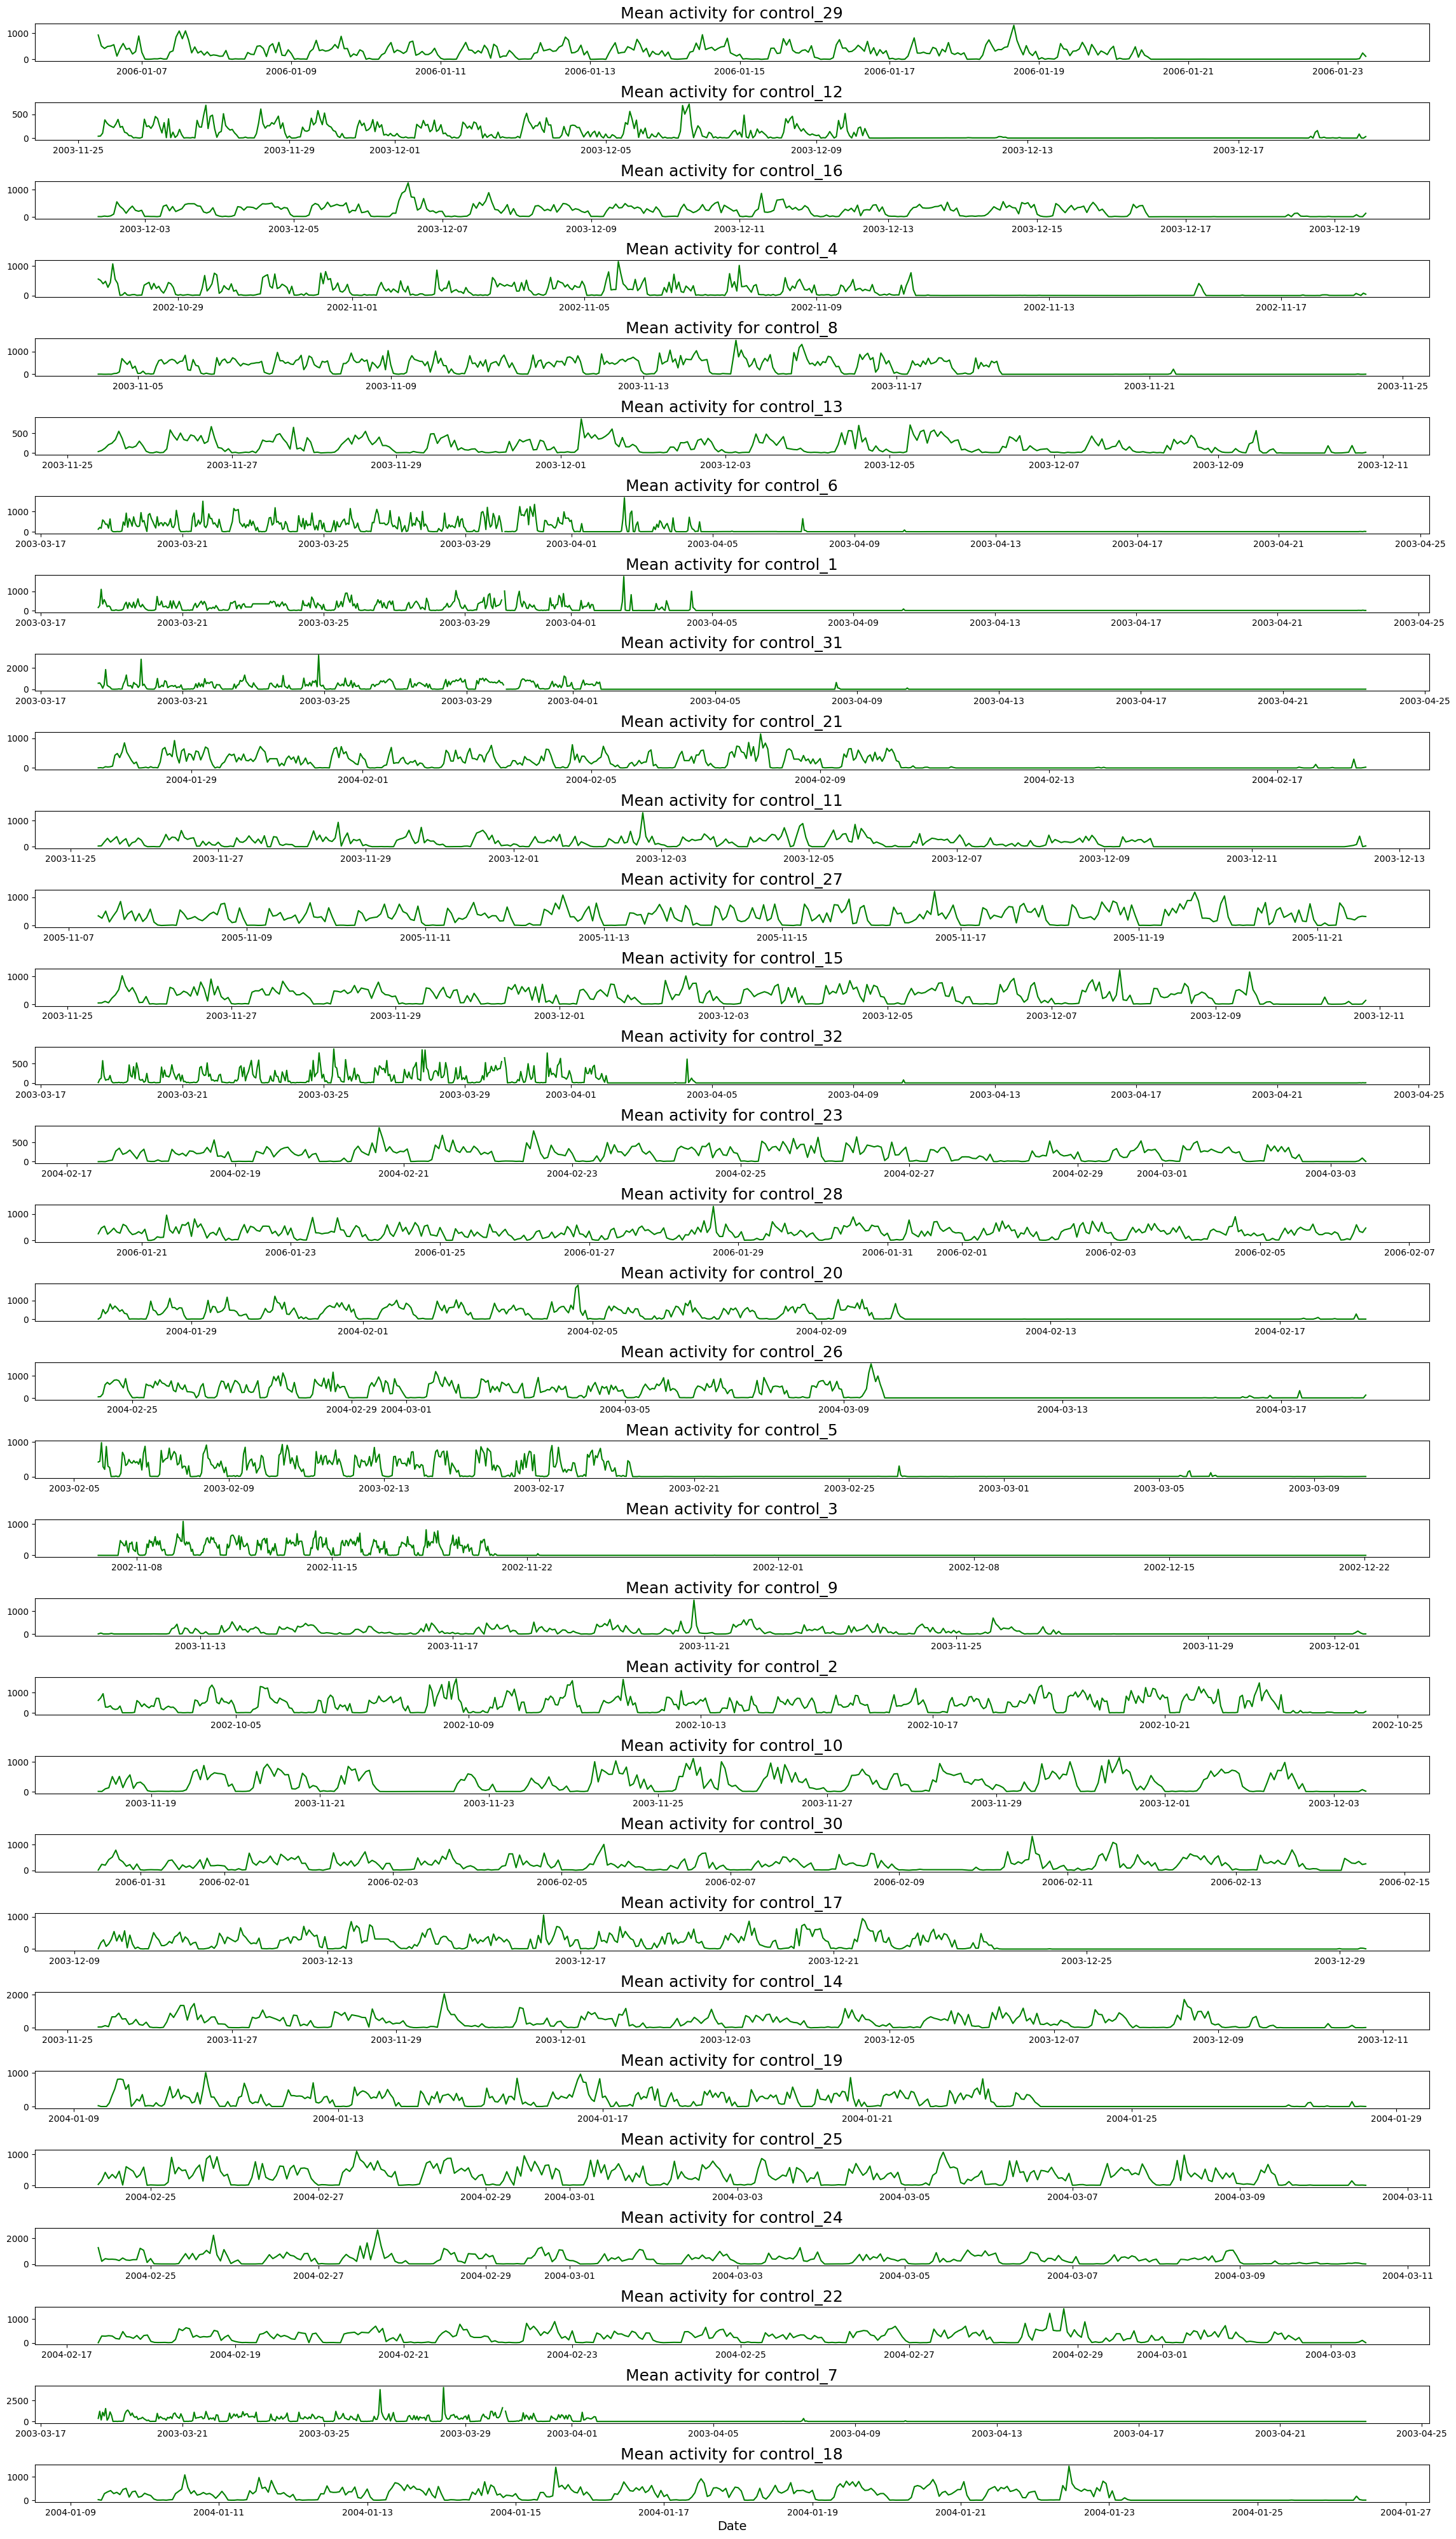

In [11]:
fig, axes = plt.subplots(32, 1, figsize=(23, 40))
cnt = 0
for i in range(32):
    control = controls[cnt]
    axes[i].plot(control.index, control.mean_activity, color='g')
    axes[i].set_title(f'Mean activity for {control.source[1]}', fontsize=18)
    cnt += 1

plt.xlabel('Date', fontsize=14)
fig.tight_layout(pad=1.0)
fig.savefig('Mean activity of control group.jpg', dpi=100)
plt.show()

In [12]:
condition.head()

,mean_activity,std_activity,zero_activity_proportion,source
timestamp,,,,
2004-09-28 09:00:00,49.600000,164.921423,25,NaN
2004-09-28 10:00:00,502.316667,423.724706,6,condition_11
2004-09-28 11:00:00,219.216667,338.811387,16,condition_11
2004-09-28 12:00:00,137.716667,181.353956,12,condition_11
2004-09-28 13:00:00,510.700000,601.712114,13,condition_11


In [13]:
control_df.head()

,mean_activity,std_activity,zero_activity_proportion,source
timestamp,,,,
2004-01-09 09:00:00,24.783333,66.219228,46,control_18
2004-01-09 10:00:00,2.383333,18.461221,59,control_18
2004-01-09 11:00:00,279.550000,276.415336,4,control_18
2004-01-09 12:00:00,352.916667,261.503689,0,control_18
2004-01-09 13:00:00,407.766667,386.204055,0,control_18


## Modeling

In [14]:
def nextday(dates):
    for date in dates:
        yield date

In [15]:
def zero_count(series):
    return list(series).count(0)

In [16]:
def extractfeatures(X, date):
    mask = X['date'] == date
    d = {
        'mean_log_activity': X[mask]['log_activity'].mean(),
        'std_log_activity': X[mask]['log_activity'].std(),
        'min_log_activity': X[mask]['log_activity'].min(),
        'max_log_activity': X[mask]['log_activity'].max(),
        'zero_proportion_activity': zero_count(X[mask]['log_activity'])
    }
    return d

In [17]:
class ExtractData(BaseEstimator, TransformerMixin):

    def __init__(self, path):
        self.path = path
        self.X = []

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        dirs = os.listdir(self.path)

        for filepath in sorted(dirs, key=lambda x: x.split('_')[0]):
            condition = filepath.split('.')[0]
            if filepath.endswith('.csv'):
                X = pd.read_csv(self.path + filepath)
                X['log_activity'] = np.log(X['activity'] + 1)
                dates = X.date.unique()

                for date in nextday(dates):
                    d = extractfeatures(X, date)
                    d['source'] = condition
                    self.X.append(d)


        return pd.DataFrame(self.X)

In [18]:
e = ExtractData(path='/content/depresjon/data/condition/')
conditions = e.fit_transform(X=None, y=None)
conditions['state'] = 1

In [19]:
conditions.tail()

,mean_log_activity,std_log_activity,min_log_activity,max_log_activity,zero_proportion_activity,source,state
400,1.804831,2.392150,0.0,7.319865,852,condition_11,1
401,1.695806,2.438653,0.0,7.509335,917,condition_11,1
402,1.025791,1.910986,0.0,7.005789,1079,condition_11,1
403,0.820158,2.004344,0.0,8.162516,1211,condition_11,1
404,0.382965,1.416033,0.0,6.942157,483,condition_11,1


In [20]:
e = ExtractData(path='/content/depresjon/data/control/')
controls = e.fit_transform(X=None, y=None)
controls['state'] = 0

In [21]:
full_df = pd.concat([controls, conditions], ignore_index=True)
full_df.head()

,mean_log_activity,std_log_activity,min_log_activity,max_log_activity,zero_proportion_activity,source,state
0,5.317621,1.723278,0.0,8.446556,15,control_29,0
1,3.622288,2.784238,0.0,8.106213,427,control_29,0
2,3.225816,2.739491,0.0,7.920447,528,control_29,0
3,3.837219,2.744049,0.0,7.920447,431,control_29,0
4,3.695253,2.689498,0.0,7.951559,447,control_29,0


In [38]:
full_df.shape

(1144, 7)

In [23]:
#full_df = full_df.sample(frac=1)

In [39]:
import numpy as np
import random

SEED = 316890
np.random.seed(SEED)
random.seed(SEED)

In [40]:
# Get unique participant IDs
participant_ids = full_df['source'].unique()
np.random.shuffle(participant_ids)

n_total = len(participant_ids)
n_train = int(0.6 * n_total)
n_valid = int(0.2 * n_total)

train_ids = participant_ids[:n_train]
valid_ids = participant_ids[n_train:n_train + n_valid]
test_ids  = participant_ids[n_train + n_valid:]

train_df = full_df[full_df['source'].isin(train_ids)]
valid_df = full_df[full_df['source'].isin(valid_ids)]
test_df  = full_df[full_df['source'].isin(test_ids)]

In [41]:
X_train = train_df.drop(['state', 'source'], axis=1)
y_train = train_df['state']
X_valid = valid_df.drop(['state', 'source'], axis=1)
y_valid = valid_df['state']
X_test  = test_df.drop(['state', 'source'], axis=1)
y_test  = test_df['state']

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Logistic Regression
lr = LogisticRegression(random_state=SEED, max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("LOGISTIC REGRESSION REPORT:")
print(classification_report(y_test, y_pred_lr))

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=SEED)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("RANDOM FOREST REPORT:")
print(classification_report(y_test, y_pred_rf))

# XGBoost
xgb = XGBClassifier(n_estimators=100, random_state=SEED, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("XGBOOST REPORT:")
print(classification_report(y_test, y_pred_xgb))

LOGISTIC REGRESSION REPORT:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       187
           1       0.59      0.26      0.36        38

    accuracy                           0.84       225
   macro avg       0.73      0.61      0.64       225
weighted avg       0.82      0.84      0.82       225

RANDOM FOREST REPORT:
              precision    recall  f1-score   support

           0       0.88      0.91      0.89       187
           1       0.45      0.37      0.41        38

    accuracy                           0.82       225
   macro avg       0.66      0.64      0.65       225
weighted avg       0.80      0.82      0.81       225

XGBOOST REPORT:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       187
           1       0.25      0.21      0.23        38

    accuracy                           0.76       225
   macro avg       0.55      0.54      0.54       225
weighted

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [03:34:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# 1. Optuna - Random Forest

In [43]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# Use Optuna's TPE sampler with seed
sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(direction='maximize', sampler=sampler)

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)

    # Model with trial parameters
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=SEED,
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    return f1_score(y_valid, y_pred, average='macro')

study.optimize(objective, n_trials=50)
print("Best trial:")
print(study.best_trial)

[I 2025-12-03 03:35:16,764] A new study created in memory with name: no-name-596b75f7-dbae-44f6-93ac-f9ecff4ec144
[I 2025-12-03 03:35:16,953] Trial 0 finished with value: 0.4641025641025641 and parameters: {'n_estimators': 86, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.4641025641025641.
[I 2025-12-03 03:35:17,155] Trial 1 finished with value: 0.5018335166850019 and parameters: {'n_estimators': 93, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.5018335166850019.
[I 2025-12-03 03:35:17,497] Trial 2 finished with value: 0.4784211369828514 and parameters: {'n_estimators': 163, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.5018335166850019.
[I 2025-12-03 03:35:17,772] Trial 3 finished with value: 0.46846145033795394 and parameters: {'n_estimators': 125, 'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 1 with value

Best trial:
FrozenTrial(number=1, state=<TrialState.COMPLETE: 1>, values=[0.5018335166850019], datetime_start=datetime.datetime(2025, 12, 3, 3, 35, 16, 954342), datetime_complete=datetime.datetime(2025, 12, 3, 3, 35, 17, 154944), params={'n_estimators': 93, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=200, log=False, low=50, step=1), 'max_depth': IntDistribution(high=20, log=False, low=3, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=5, log=False, low=1, step=1)}, trial_id=1, value=None)


In [44]:
# Refit Random Forest on TRAIN data with best params, then evaluate on TEST set
best_params = study.best_trial.params

best_rf = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=SEED
)
best_rf.fit(X_train, y_train)
y_pred_test = best_rf.predict(X_test)

from sklearn.metrics import classification_report, f1_score

print("Random Forest Test Performance (Best Optuna Params):")
print(classification_report(y_test, y_pred_test))
print("Test Macro F1-score:", f1_score(y_test, y_pred_test, average='macro'))

Random Forest Test Performance (Best Optuna Params):
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       187
           1       0.62      0.39      0.48        38

    accuracy                           0.86       225
   macro avg       0.76      0.67      0.70       225
weighted avg       0.84      0.86      0.84       225

Test Macro F1-score: 0.7006983704689058


Test ROC AUC: 0.7911623979735435


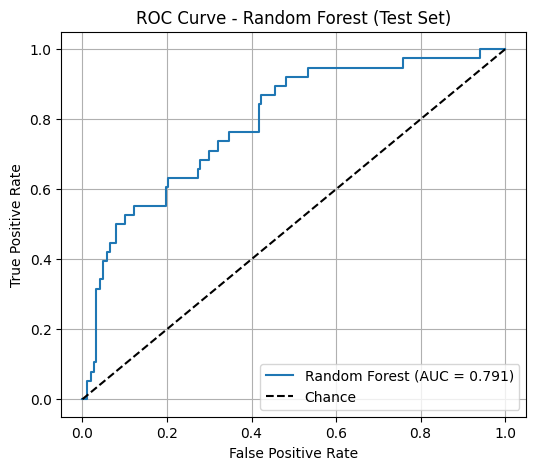

In [45]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predict probabilities for the positive class
y_proba_test = best_rf.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)
auc_score = roc_auc_score(y_test, y_proba_test)
print("Test ROC AUC:", auc_score)

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {auc_score:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

# 2. Optuna - Logistic Regression

In [46]:
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

sampler = optuna.samplers.TPESampler(seed=SEED)
study_lr = optuna.create_study(direction='maximize', sampler=sampler)

def objective_lr(trial):
    C = trial.suggest_loguniform('C', 1e-3, 1e2)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear'])
    clf = LogisticRegression(
        C=C,
        solver=solver,
        random_state=SEED,
        max_iter=1000
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    return f1_score(y_valid, y_pred, average='macro')

study_lr.optimize(objective_lr, n_trials=50)
print("Best Logistic Regression trial:")
print(study_lr.best_trial)

[I 2025-12-03 03:38:19,259] A new study created in memory with name: no-name-271961d5-259b-40a6-a225-0a67fb2f5502
/tmp/ipython-input-2154240025.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
[I 2025-12-03 03:38:19,272] Trial 0 finished with value: 0.2763157894736842 and parameters: {'C': 0.016272503785539197, 'solver': 'liblinear'}. Best is trial 0 with value: 0.2763157894736842.
/tmp/ipython-input-2154240025.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
[I 2025-12-03 03:38:19,285] Trial 1 finished with value: 0.4914141414141414 and parameters: {'C': 1.350078791036959, '

Best Logistic Regression trial:
FrozenTrial(number=16, state=<TrialState.COMPLETE: 1>, values=[0.4953432218006209], datetime_start=datetime.datetime(2025, 12, 3, 3, 38, 19, 563665), datetime_complete=datetime.datetime(2025, 12, 3, 3, 38, 19, 575493), params={'C': 0.7133076872319757, 'solver': 'liblinear'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'C': FloatDistribution(high=100.0, log=True, low=0.001, step=None), 'solver': CategoricalDistribution(choices=('lbfgs', 'liblinear'))}, trial_id=16, value=None)


In [47]:
best_params_lr = study_lr.best_trial.params

best_lr = LogisticRegression(
    C=best_params_lr['C'],
    solver=best_params_lr['solver'],
    random_state=SEED,
    max_iter=1000
)
best_lr.fit(X_train, y_train)
y_pred_test_lr = best_lr.predict(X_test)

from sklearn.metrics import classification_report, f1_score

print("Logistic Regression Test Performance (Best Optuna Params):")
print(classification_report(y_test, y_pred_test_lr))
print("Test Macro F1-score:", f1_score(y_test, y_pred_test_lr, average='macro'))

Logistic Regression Test Performance (Best Optuna Params):
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       187
           1       0.56      0.26      0.36        38

    accuracy                           0.84       225
   macro avg       0.71      0.61      0.63       225
weighted avg       0.81      0.84      0.82       225

Test Macro F1-score: 0.6328861493836113


Test ROC AUC (Logistic Regression): 0.7907402195327892


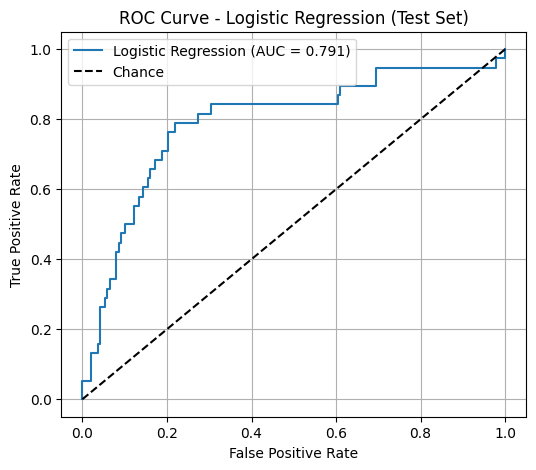

In [48]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predict probabilities for the positive class (label 1)
y_proba_test_lr = best_lr.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_proba_test_lr)
auc_score_lr = roc_auc_score(y_test, y_proba_test_lr)
print("Test ROC AUC (Logistic Regression):", auc_score_lr)

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr_lr, tpr_lr,
         label=f"Logistic Regression (AUC = {auc_score_lr:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

# 3. Optuna - XGBoost

In [49]:
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

sampler = optuna.samplers.TPESampler(seed=SEED)
study_xgb = optuna.create_study(direction='maximize', sampler=sampler)

def objective_xgb(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)

    clf = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        random_state=SEED,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    return f1_score(y_valid, y_pred, average='macro')

study_xgb.optimize(objective_xgb, n_trials=50)
print("Best XGBoost trial:")
print(study_xgb.best_trial)

[I 2025-12-03 03:39:37,482] A new study created in memory with name: no-name-24ec99ba-8f97-4e80-bfc4-e72748ba5c4c
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [03:39:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-12-03 03:39:38,612] Trial 0 finished with value: 0.5210084033613445 and parameters: {'n_estimators': 86, 'max_depth': 18, 'learning_rate': 0.2701449022011358, 'subsample': 0.850428729184137}. Best is trial 0 with value: 0.5210084033613445.
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [03:39:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-12-03 03:39:39,406] Trial 1 finished with value: 0.5190537555228277 and parameters: {'n_estimators': 93, 'max_depth': 14, 'learning_rate': 0.2506213762535415, 'subsample': 0.705895

Best XGBoost trial:
FrozenTrial(number=19, state=<TrialState.COMPLETE: 1>, values=[0.5388858246001103], datetime_start=datetime.datetime(2025, 12, 3, 3, 39, 42, 317697), datetime_complete=datetime.datetime(2025, 12, 3, 3, 39, 42, 357842), params={'n_estimators': 71, 'max_depth': 3, 'learning_rate': 0.18762755492324368, 'subsample': 0.7902814281842401}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=200, log=False, low=50, step=1), 'max_depth': IntDistribution(high=20, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.6, step=None)}, trial_id=19, value=None)


In [50]:
best_params_xgb = study_xgb.best_trial.params

best_xgb = XGBClassifier(
    n_estimators=best_params_xgb['n_estimators'],
    max_depth=best_params_xgb['max_depth'],
    learning_rate=best_params_xgb['learning_rate'],
    subsample=best_params_xgb['subsample'],
    random_state=SEED,
    use_label_encoder=False,
    eval_metric='logloss'
)
best_xgb.fit(X_train, y_train)
y_pred_test_xgb = best_xgb.predict(X_test)

from sklearn.metrics import classification_report, f1_score

print("XGBoost Test Performance (Best Optuna Params):")
print(classification_report(y_test, y_pred_test_xgb))
print("Test Macro F1-score:", f1_score(y_test, y_pred_test_xgb, average='macro'))

XGBoost Test Performance (Best Optuna Params):
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       187
           1       0.50      0.37      0.42        38

    accuracy                           0.83       225
   macro avg       0.69      0.65      0.66       225
weighted avg       0.81      0.83      0.82       225

Test Macro F1-score: 0.6626420454545454


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [03:39:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Test ROC AUC (XGBoost): 0.748592738530819


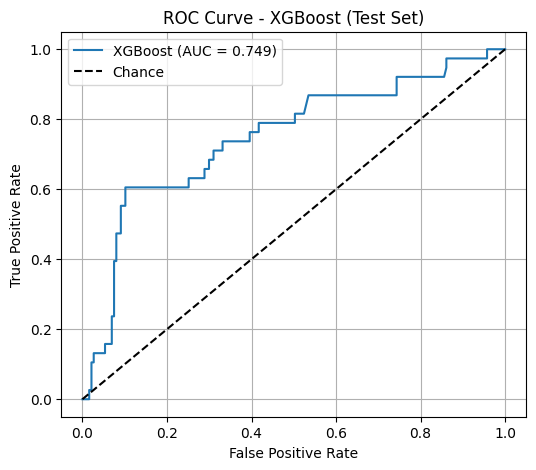

In [51]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predict probabilities for the positive class (label 1)
y_proba_test_xgb = best_xgb.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_proba_test_xgb)
auc_score_xgb = roc_auc_score(y_test, y_proba_test_xgb)
print("Test ROC AUC (XGBoost):", auc_score_xgb)

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr_xgb, tpr_xgb,
         label=f"XGBoost (AUC = {auc_score_xgb:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

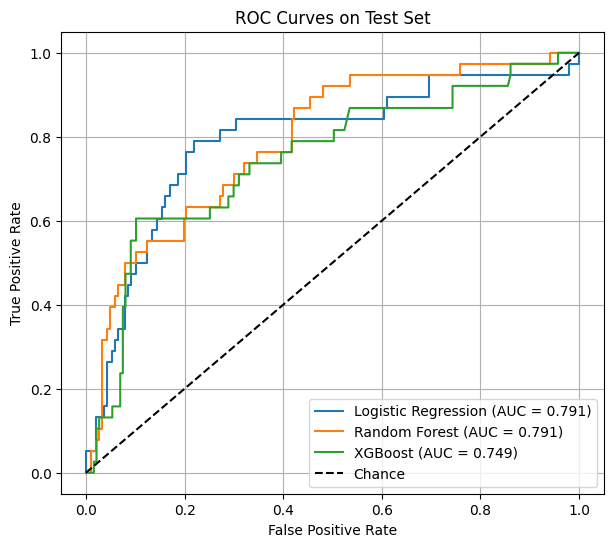

In [52]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Probabilities for positive class
y_proba_lr  = best_lr.predict_proba(X_test)[:, 1]
y_proba_rf  = best_rf.predict_proba(X_test)[:, 1]
y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

# ROC + AUC for each model
fpr_lr,  tpr_lr,  _ = roc_curve(y_test, y_proba_lr)
fpr_rf,  tpr_rf,  _ = roc_curve(y_test, y_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

auc_lr  = roc_auc_score(y_test, y_proba_lr)
auc_rf  = roc_auc_score(y_test, y_proba_rf)
auc_xgb = roc_auc_score(y_test, y_proba_xgb)

# Plot all curves
plt.figure(figsize=(7, 6))
plt.plot(fpr_lr,  tpr_lr,  label=f"Logistic Regression (AUC = {auc_lr:.3f})")
plt.plot(fpr_rf,  tpr_rf,  label=f"Random Forest (AUC = {auc_rf:.3f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves on Test Set")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()